## Detector model: 3-level system

In [1]:
from sympy import *
#from sympy.physics.matrices import mdft
from sympy.physics.quantum import TensorProduct
from sympy.functions.special.delta_functions import Heaviside
from sympy.physics.quantum.dagger import Dagger

from sympy.stats import ContinuousRV, variance, std

from sympy.plotting import plot, plot3d_parametric_line

import numpy as np

import scipy.integrate

import matplotlib
import matplotlib.pyplot as plt

# matplotlib.rcParams['text.usetex'] = False

# https://matplotlib.org/gallery/mplot3d/lines3d.html?highlight=parametric
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [2]:
from IPython.display import display, Latex #, Math

In [3]:
init_printing ()

In [4]:
gamma = Symbol('gamma', real=True, positive=True)
t = Symbol('t', real=True)
tprime = Symbol('t\'', real=True)
omega = Symbol('omega', real=True)
nu = Symbol('nu', real=True)

In [5]:
H = Matrix ([
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0]
])

In [6]:
H.eigenvects()

⎡⎛      ⎡⎡-1⎤⎤⎞  ⎛        ⎡⎡ 1 ⎤⎤⎞  ⎛       ⎡⎡1 ⎤⎤⎞⎤
⎢⎜      ⎢⎢  ⎥⎥⎟  ⎜        ⎢⎢   ⎥⎥⎟  ⎜       ⎢⎢  ⎥⎥⎟⎥
⎢⎜0, 1, ⎢⎢0 ⎥⎥⎟, ⎜-√2, 1, ⎢⎢-√2⎥⎥⎟, ⎜√2, 1, ⎢⎢√2⎥⎥⎟⎥
⎢⎜      ⎢⎢  ⎥⎥⎟  ⎜        ⎢⎢   ⎥⎥⎟  ⎜       ⎢⎢  ⎥⎥⎟⎥
⎣⎝      ⎣⎣1 ⎦⎦⎠  ⎝        ⎣⎣ 1 ⎦⎦⎠  ⎝       ⎣⎣1 ⎦⎦⎠⎦

In [7]:
U_t = exp(-I*H*t)

In [8]:
psi_0 = Matrix([1, (1+I)/sqrt(2), 0])/sqrt(2)
psi_0

⎡ √2  ⎤
⎢ ──  ⎥
⎢ 2   ⎥
⎢     ⎥
⎢1   ⅈ⎥
⎢─ + ─⎥
⎢2   2⎥
⎢     ⎥
⎣  0  ⎦

In [9]:
unitary_psi_t = U_t @ psi_0

In [10]:
unitary_psi_t

⎡                                          ⎛ √2⋅ⅈ⋅t        -√2⋅ⅈ⋅t⎞⎤
⎢                                          ⎜ℯ         1   ℯ       ⎟⎥
⎢        ⎛      √2⋅ⅈ⋅t       -√2⋅ⅈ⋅t⎞   √2⋅⎜─────── + ─ + ────────⎟⎥
⎢⎛1   ⅈ⎞ ⎜  √2⋅ℯ         √2⋅ℯ       ⎟      ⎝   4      2      4    ⎠⎥
⎢⎜─ + ─⎟⋅⎜- ────────── + ───────────⎟ + ───────────────────────────⎥
⎢⎝2   2⎠ ⎝      4             4     ⎠                2             ⎥
⎢                                                                  ⎥
⎢     ⎛      √2⋅ⅈ⋅t       -√2⋅ⅈ⋅t⎞                                 ⎥
⎢     ⎜  √2⋅ℯ         √2⋅ℯ       ⎟                                 ⎥
⎢  √2⋅⎜- ────────── + ───────────⎟           ⎛ √2⋅ⅈ⋅t    -√2⋅ⅈ⋅t⎞  ⎥
⎢     ⎝      4             4     ⎠   ⎛1   ⅈ⎞ ⎜ℯ         ℯ       ⎟  ⎥
⎢  ─────────────────────────────── + ⎜─ + ─⎟⋅⎜─────── + ────────⎟  ⎥
⎢                 2                  ⎝2   2⎠ ⎝   2         2    ⎠  ⎥
⎢                                                                  ⎥
⎢                                 

In [11]:
prob_t = Matrix([0, 0, 0])
for i in 0, 1, 2:
    prob_t[i] = abs(unitary_psi_t[i])**2

In [12]:
prob_t

⎡   2⋅√2⋅ⅈ⋅t      2⋅√2⋅ⅈ⋅t    √2⋅ⅈ⋅t      √2⋅ⅈ⋅t         -√2⋅ⅈ⋅t      -√2⋅ⅈ⋅t 
⎢  ℯ           ⅈ⋅ℯ           ℯ         ⅈ⋅ℯ         5    ℯ          ⅈ⋅ℯ        
⎢- ───────── - ─────────── + ─────── - ───────── + ── + ──────── + ────────── 
⎢      32           16          8          8       16      8           8      
⎢                                                                             
⎢                         2⋅√2⋅ⅈ⋅t      2⋅√2⋅ⅈ⋅t        -2⋅√2⋅ⅈ⋅t      -2⋅√2⋅ⅈ
⎢                        ℯ           ⅈ⋅ℯ           3   ℯ            ⅈ⋅ℯ       
⎢                        ───────── + ─────────── + ─ + ────────── - ──────────
⎢                            16           8        8       16            8    
⎢                                                                             
⎢   2⋅√2⋅ⅈ⋅t      2⋅√2⋅ⅈ⋅t    √2⋅ⅈ⋅t      √2⋅ⅈ⋅t         -√2⋅ⅈ⋅t      -√2⋅ⅈ⋅t 
⎢  ℯ           ⅈ⋅ℯ           ℯ         ⅈ⋅ℯ         5    ℯ          ⅈ⋅ℯ        
⎢- ───────── - ─────────── - ─────── + ───────── + ─

In [13]:
simplify(
    prob_t[0] + prob_t[1] + prob_t[2]
)

In [14]:
unitary_psi_n = lambdify(t, unitary_psi_t, 'numpy')
_prob_n = lambdify(t, prob_t, 'numpy')
def prob_n(_t):
    return np.real(_prob_n(_t))

In [111]:
def phase_color(_z):
    return np.imag(_z)

<!--
#### Complex argument color code
* <span style="color: #fe0">__Yellow__</span> (or generally the "highest"): imaginary, positive
* <span style="color: #086">__Green__ </span> (or generally the "midrange"): real
* <span style="color: #408">__Purple__</span> (or generally the "lowest"): imaginary, negative
-->

In [112]:
TMIN, TMAX = 0, 3*pi/sqrt(2)
TMIN_N, TMAX_N = float(TMIN), float(TMAX)

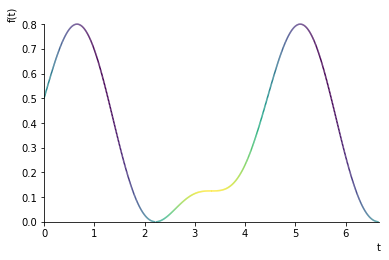

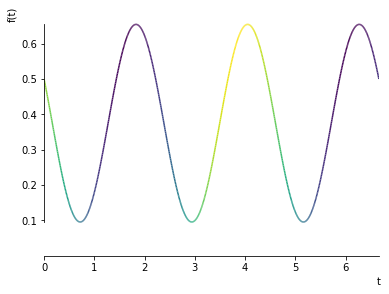

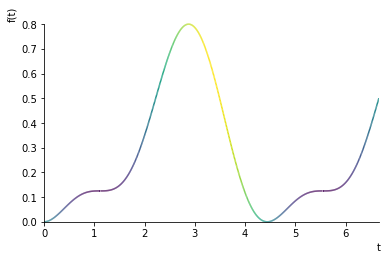

In [113]:
for i in 0, 1, 2:
    pl = plot(
        prob_t[i],
        (t, TMIN, TMAX),
        adaptive=False, nb_of_points=1000, show=False)
    # Need the numeric version to customize color function
    pl[0].line_color = lambda _t: phase_color( unitary_psi_n(_t)[i] )
    pl.axis_center = (0, 0)
    pl.show()

In [81]:
NPLOTPOINTS = 1000

In [82]:
times = np.linspace(TMIN_N, TMAX_N, num=NPLOTPOINTS)

In [83]:
probs = np.zeros((3, NPLOTPOINTS))

In [84]:
probs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [85]:
for i in 0, 1, 2:
    probs[i] = prob_n(times)[i]

In [86]:
UNISYM = {
    'psi': u'\u03C8',
    '^2' : u'\u00B2'
}
PROB_LABELS     = ['', '', '']
PROB_AMP_LABELS = ['', '', '']
                
for i in 0, 1, 2:
    PROB_AMP_LABELS[i] = '<' + str(i) + '|' + UNISYM['psi'] + '>'
    PROB_LABELS[i]     = '|' + PROB_AMP_LABELS[i] + '|' + UNISYM['^2']

https://matplotlib.org/gallery/lines_bars_and_markers/stackplot_demo.html#sphx-glr-gallery-lines-bars-and-markers-stackplot-demo-py

In [87]:
prob_stack = np.vstack(probs)

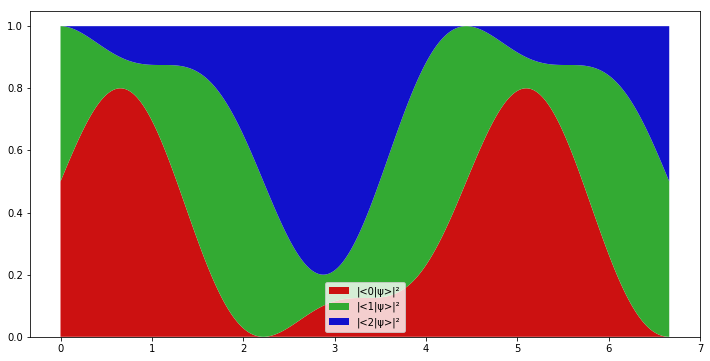

In [110]:
labels = PROB_LABELS
colors = ["#cc1111", "#33aa33", "#1111cc"]

fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(times, probs[0], probs[1], probs[2], labels=labels, colors=colors)
ax.legend(loc='lower center')
plt.show()

In [89]:
rgbs = []
for i in range(NPLOTPOINTS):
    rgbs.append(
        (
            probs[0][i],
            probs[1][i],
            probs[2][i]
        )
    )

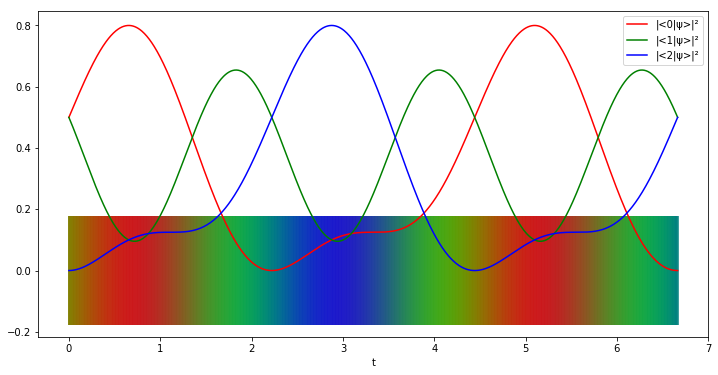

In [101]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('t')
ax.scatter(times, np.zeros(NPLOTPOINTS),
            c=rgbs, marker='|', s=12000)

# "virtual", don't really want to show, only for legend
_c = ['r', 'g', 'b']
for i in 0, 1, 2:
    ax.plot(
        times, probs[i],
        c=_c[i],
        #linewidth=1,
    )
    
ax.legend(
    PROB_LABELS,
    loc='upper right'
)

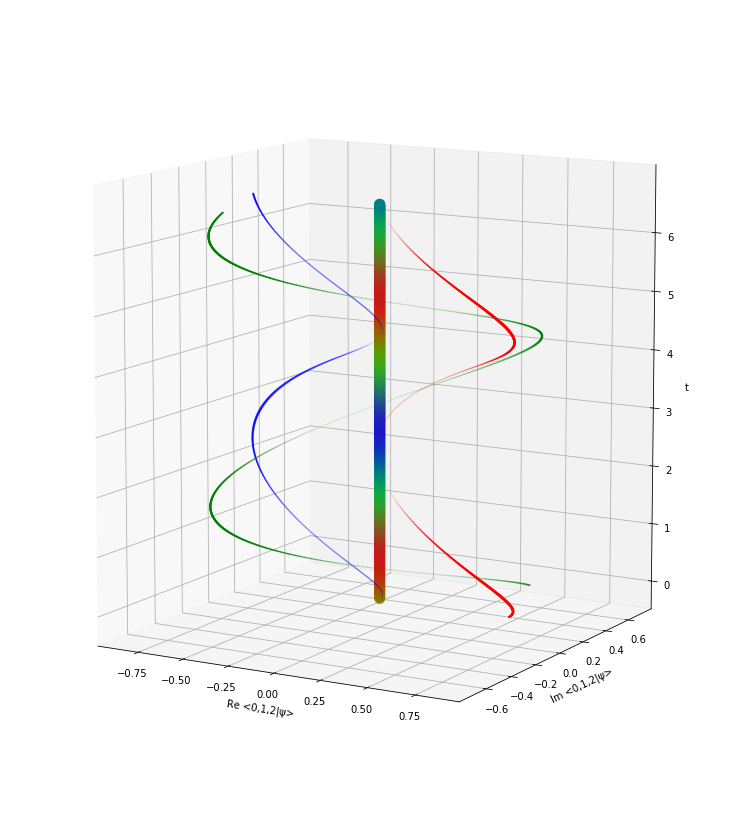

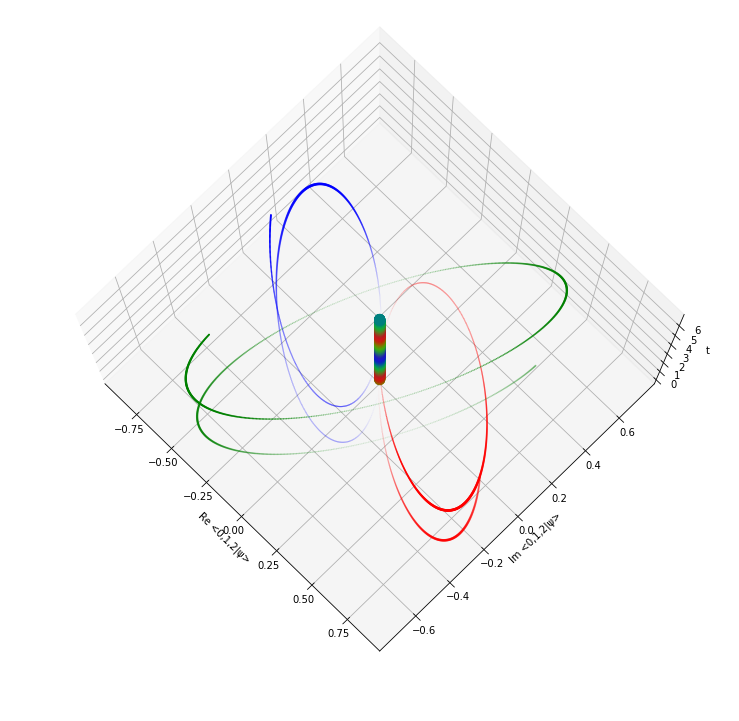

In [92]:
# 3D parametric plot
for (vertical_angle, horizontal_angle, height, width) in (10, -60, 15, 13), (80, -45, 13, 13):
    fig = plt.figure(figsize=(width, height))


    ax = fig.gca(projection='3d')

    ax.view_init(vertical_angle, horizontal_angle) # rotate 3d point of view

    ax.set_xlabel('Re <0,1,2|\u03C8>')
    ax.set_ylabel('Im <0,1,2|\u03C8>')
    ax.set_zlabel('t')

    ax.scatter(
        np.zeros(NPLOTPOINTS, dtype=np.float),
        np.zeros(NPLOTPOINTS, dtype=np.float),
        times,

        c = rgbs,
        s = 100
    )
    for i in 0, 1, 2:
        ax.scatter(
            np.real(unitary_psi_n(times)[i][0]),
            np.imag(unitary_psi_n(times)[i][0]),
            times,

            marker = '.',
            #depthshade=False,
            s = (probs[i]**2.4)*20,
            c = _c[i]
        )

## Complex potential (detection by absorption)

Need to switch everything to numeric.

In [29]:
#H = np.array([
#    [0, 1, 0],
#    [1, 0, 1],
#    [0, 1, 0]
#], dtype=np.complex)

In [30]:
#np.float(TMAX).__class__
